Running simulation 50 times...


Running Simulations: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s]

All runs completed. Calculating average accuracy...


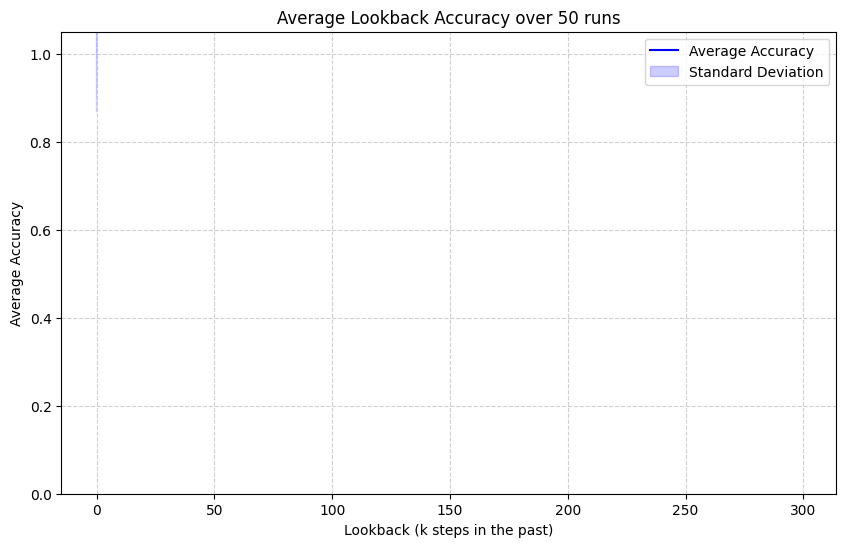

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

from memory_module import OnlineModule, lookback_accuracy_fn
from synthetic_datasets import InContextRecallDataset
from losses import windowed_p_loss

#torch.manual_seed(0) # You can uncomment this for reproducible runs

class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        return self.linear(x)
    
class selfattn(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()


# --- Configuration ---
n_features = 10
n_samples = 300
num_runs = 50  # The number of times 'k' to run the simulation
loss_fn = windowed_p_loss
optimizer_class = torch.optim.SGD
optimizer_kwargs = {'lr': 0.1, 'momentum': 0.9}
context_size = 10

# --- Main execution logic ---

# Store the lookback accuracy from each run
all_lookback_accuracies = []

print(f"Running simulation {num_runs} times...")

for i in tqdm(range(num_runs), desc="Running Simulations"):
    # 1. Re-initialize the model for each run to start from a fresh state.
    #    This is crucial for a fair average.
    base_model = LinearModel(n_features, n_features)

    online_module = OnlineModule(
        model=base_model,
        loss_fn=loss_fn,
        optimizer_class=optimizer_class,
        optimizer_kwargs=optimizer_kwargs,
        eval_fn=lookback_accuracy_fn,
        context_size=context_size
    )

    # 2. Generate a new random dataset for each run.
    my_dataset = InContextRecallDataset(n_samples, n_features, context_size, 0, 0)

    # 3. Extract and stack the data into tensors.
    x_list, y_list = [], []
    for j in range(len(my_dataset)):
        x_sample, y_sample = my_dataset[j]
        x_list.append(x_sample[-1])
        y_list.append(y_sample[-1])

    x_sequence = torch.stack(x_list)
    y_target_sequence = torch.stack(y_list)

    # 4. Run the simulation and get the lookback accuracy.
    preds, losses, lookback_acc, _ = online_module(x_sequence, y_target_sequence)

    # 5. Store the result of the run.
    all_lookback_accuracies.append(lookback_acc)
    
    # Optional: Print progress
    #if (i + 1) % 10 == 0:
    #    print(f"  Completed run {i + 1}/{num_runs}")

print("All runs completed. Calculating average accuracy...")

# --- Averaging and Plotting ---
#plt can handle pytorch. no need to convert to numpy

# Convert the list of lists into a 2D tensor for easy computation
accuracies_tensor = torch.tensor(all_lookback_accuracies)

# Calculate the mean and standard deviation across all runs
avg_lookback_acc = torch.mean(accuracies_tensor, dim=0)
std_dev_acc = torch.std(accuracies_tensor, dim=0)

# 'lookback' is a list of numbers from 0 to n-1
lookback = list(range(n_samples))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(lookback, avg_lookback_acc, label='Average Accuracy', color='blue')

# Add a shaded region for the standard deviation
plt.fill_between(
    lookback,
    (avg_lookback_acc - std_dev_acc).numpy(),
    (avg_lookback_acc + std_dev_acc).numpy(),
    color='blue',
    alpha=0.2,
    label='Standard Deviation'
)


# Add labels and a title for clarity
plt.xlabel("Lookback (k steps in the past)")
plt.ylabel("Average Accuracy")
plt.title(f"Average Lookback Accuracy over {num_runs} runs")
plt.legend()

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05) # Set y-axis limits from 0 to 1 for accuracy

# Show the plot
plt.show()